# Ch 4 of Montgomery and Peck

In [16]:
%pylab inline
matplotlib.rcParams['figure.figsize'] = (12, 10)
import pandas as pd
import statsmodels.formula.api as sm
from scipy import stats
from patsy import dmatrices
from scipy import linalg

Populating the interactive namespace from numpy and matplotlib


## Summary of equations

Equation $\boldsymbol{y = X \beta + \varepsilon}$, where $\boldsymbol X$ is (n, k),  $\boldsymbol \beta$ is (k, 1), and $\boldsymbol y$, $\boldsymbol \varepsilon$ are (n,1).

We are minimizing the sum of squares $S(\boldsymbol{\beta}) = \sum_{i=1}^n \varepsilon_i^2 = \boldsymbol{\varepsilon' \varepsilon} = \boldsymbol{(y - X\beta)'(y - X\beta)} = \boldsymbol{y'y - 2\beta'X'y + \beta'X'X\beta}$. Taking derivative w.r.t. $\boldsymbol\beta$ we get $\boldsymbol{X'X\hat\beta = X'y}$, where we replaced $\boldsymbol\beta$ with $\boldsymbol {\hat\beta}$ to represent that, at the point of minimal S, the estimator matches the true model.

The solution of the normal equation (above) is $\boldsymbol{\hat\beta} = \boldsymbol{(X'X)^{-1}X'y}$, provided that $\boldsymbol{(X'X)^{-1}}$ exists. This is the case if the regressors are linearly independent.

We can get the fitted values for the observed quantities $\boldsymbol{\hat y} = \boldsymbol{X\hat\beta} = \boldsymbol{X(X'X)^{-1}X'y} = \boldsymbol{Hy}$. $\boldsymbol{H}$ is called the hat matrix and it maps the vector of observed values to a vector of fitted values.

In [6]:
%%file delivery-time-data.csv
"Observation number", "Delivery time (minutes)", "Number of cases", "Distance (feet)"
1, 16.68, 7, 560
2, 11.50, 3, 220
3, 12.05, 3, 340
4, 14.88, 4, 80
5, 13.75, 6, 150
6, 18.11, 7, 330
7, 8.00, 2, 110
8, 17.83, 7, 210
9, 79.24, 30, 1460
10, 21.50, 5, 605
11, 40.33, 16, 688
12, 21.00, 10, 215
13, 13.50, 4, 255
14, 19.75, 6, 462
15, 24.00, 9, 448
16, 29.00, 10, 776
17, 15.35, 6, 200
18, 19.00, 7, 132
19, 9.50, 3, 36
20, 35.10, 17, 770
21, 17.90, 10, 140
22, 52.32, 26, 810
23, 18.75, 9, 450
24, 19.83, 8, 635
25, 10.75, 4, 150

Overwriting delivery-time-data.csv


In [7]:
dt = pd.read_csv('delivery-time-data.csv', index_col='Observation number')
dt.columns = ['t', 'n', 'd'] # have to rename columns to use formulas

In [8]:
dt

,t,n,d
Observation number,,,
1,16.68,7,560
2,11.50,3,220
3,12.05,3,340
4,14.88,4,80
5,13.75,6,150
6,18.11,7,330
7,8.00,2,110
8,17.83,7,210
9,79.24,30,1460


In [13]:
y, X = dmatrices('t ~ n + d', data=dt)

In [66]:
fit = sm.ols('t ~ n + d', data=dt).fit()

In [68]:
print(fit.summary2())

                 Results: Ordinary least squares
Model:              OLS              Adj. R-squared:     0.956   
Dependent Variable: t                AIC:                132.8292
Date:               2015-08-05 00:35 BIC:                136.4858
No. Observations:   25               Log-Likelihood:     -63.415 
Df Model:           2                F-statistic:        261.2   
Df Residuals:       22               Prob (F-statistic): 4.69e-16
R-squared:          0.960            Scale:              10.624  
-------------------------------------------------------------------
              Coef.    Std.Err.     t      P>|t|    [0.025   0.975]
-------------------------------------------------------------------
Intercept     2.3427     1.0967   2.1360   0.0441   0.0682   4.6171
n             1.6157     0.1707   9.4630   0.0000   1.2616   1.9697
d             0.0144     0.0036   3.9824   0.0006   0.0069   0.0219
-----------------------------------------------------------------
Omnibus:       

In [38]:
XpX = linalg.pinv2(np.dot(X.T, X))
H = np.dot(X, np.dot(XpX, X.T))

In [60]:
yp = np.dot(H, y)
dt['fitted'] = yp
dt['e'] = y - yp

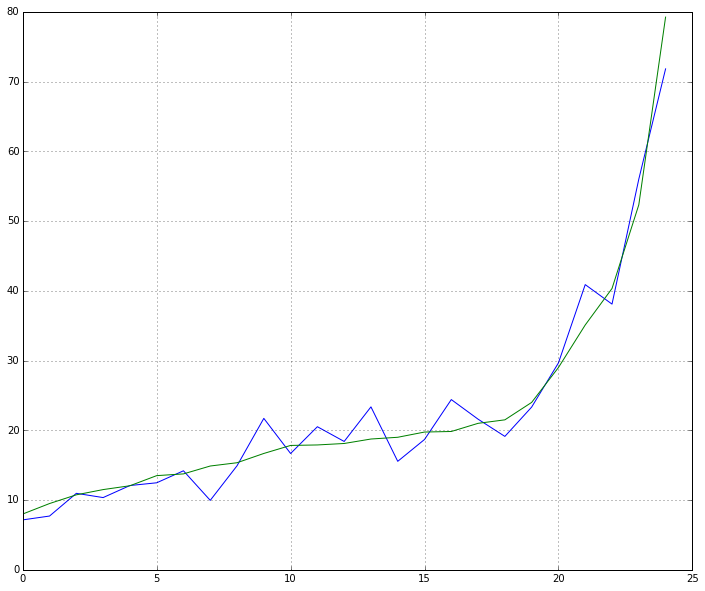

In [64]:
dt.sort('t', inplace=True)
plot(dt.fitted)
plot(dt.t)
grid()

In [134]:
# Let's try the QR decomposition example from Seber
y, X = dmatrices('t ~ n + d', data=dt)
nobs = X.shape[0] # number of observations
p = X.shape[1] # number of regressors
aug = np.zeros((nobs, p + 1), dtype=X.dtype)
aug[:, :p] = X
aug[:, p:] = y
Qd, Rd = linalg.qr(aug, mode='economic')
Qp, q = Qd[:, :p], Qd[:, p:]
R, r, d = Rd[:p, :p], Rd[:p, p:], Rd[p:, p:]
beta = linalg.solve_triangular(R, r)
yhat = np.dot(Qp, r).reshape(-1)
e = (d*q).reshape(-1)
rss = (d**2).reshape(-1)
H = np.dot(Qp, Qp.T)

In [141]:
beta

array([[ 2.34265956],
       [ 1.61565744],
       [ 0.01438864]])

In [116]:
np.asarray(dt.fitted)

array([  7.15672449,   7.7076228 ,  10.96358484,  10.35513198,
        12.0817684 ,  12.47439171,  14.19489971,   9.95638026,
        14.91433155,  21.70989825,  16.67387536,  20.51364309,
        18.40051178,  23.35846308,  15.55156169,  18.68415441,
        24.40470346,  21.59279086,  19.12607204,  23.3296858 ,
        29.66481613,  40.88808637,  38.09256071,  56.00454878,  71.81979248])